In [ ]:
import sys
#!{sys.executable} -m pip install pandas_ta

In [1]:
import pandas as pd
import pandas_datareader as pdr
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas_ta as pta

## Portfolio Backtest 
### Define functions

- <font size="3">**Order/signal generation:** </font>
    - **ma_order(df, trade_start)** - takes in price data and generate trading signal & orders using moving average strategy, also takes in trade start date to truncate the price data to desired start date 


- <font size="3">**Portfolio formation:**</font>
    - **create_pf(tickers, start, end, ma_order, trade_start)** - takes in list of tickers, order generation function, start and end date of prices for calculation of trading signals as well as trade start date. output a single df combining output from the order generation function


- <font size="3">**Portfolio allocation:**</font>
    - **equal_weight(tickers)** - takes in list of tickers and output a dictionary of tickers with eqaul weights assigned
    - **minvar_weight(tickers,start,end)** - takes in list of tickers, start and end date and output a dictionary of tickers with weights of the minimum variance portfolio
    - **maxsharpe_weight(tickers,start,end)** - takes in list of tickers, start and end date and output a dictionary of tickers with weights of the maximum sharpe ratio portfolio


- <font size="3">**Backtest:**</font>
    - **backtest(port_df, tickers, weights)** - takes in output of create_pf, list of tickers and weights, output returns without short positions and plot of returns against benchmark (NASDAQ)
    - **short_backtest(port_df, tickers, weights)** - takes in output of create_pf, list of tickers and weights, output returns with short positions and plot of returns against benchmark (NASDAQ)



### Data Source
- Yahoo finance from pandas_datareader library

### 1. Functions

In [96]:
# order / signal generation for moving average
def ma_order(df,trade_start):
    df = df.reset_index()
    df['Signal'] = df['Adj Close'].rolling(10).mean() - df['Adj Close'].rolling(60).mean()
    df['Position'] = (df['Signal'].apply(np.sign) + 1)/2
    df.drop(['High', 'Low', 'Open', 'Volume', 'Close','Signal'], axis=1, inplace=True)
    df.dropna(inplace=True)
    df['Order'] = 0
    df = df[df['Date'] >= trade_start]
    
    curr, prev = 0, 0

    for index, row in df.iterrows():
        curr = row['Position']
        if curr != prev:
            order = curr - prev
            df.at[index, 'Order'] = order
        prev = curr
    return df


In [145]:
def ma_bollinger(df,trade_start):
    df = df.reset_index()
    df['Signal'] = df['Adj Close'].rolling(10).mean() - df['Adj Close'].rolling(60).mean()
    df['MA Position'] = (df['Signal'].apply(np.sign) + 1)/2
    df['SMA'] = df['Adj Close'].rolling(20).mean()
    df['STD'] = df['Adj Close'].rolling(20).std()
    df['Lower'] = df['SMA'] - df['STD'] * 2
    df['Upper'] = df['SMA'] + df['STD'] * 2
    df['Order'] = 0
    df['BL Position'] = 0
    df.drop(['High', 'Low', 'Open', 'Volume', 'Close','Signal'], axis=1, inplace=True)
    df.dropna(inplace=True)
    df['Order'] = 0
    df['Position'] = 0
    
    prev_signal, prev_stock, prev_lower, prev_upper = 0, 0, 0, 0
    
    for index, row in df.iterrows():
        if index == 0:
            prev_stock = row['Adj Close']
            prev_lower = row['Lower']
            prev_upper = row['Upper']
            position = 0
            continue
        price = row['Adj Close']
        upper = row['Upper']
        lower = row['Lower']
        # sell when prev < prev_upper, curr > curr_upper
        if (prev_stock < prev_upper) & (price > upper):
            position = 1
        # buy when prev > prev_lower, curr < curr_lower
        elif (prev_stock > prev_lower) & (price < lower):
            position = -1
        else:
            position = prev_signal
        df.at[index,'BL Position'] = position
        prev_signal = position
        prev_stock = price
        prev_lower = lower
        prev_upper = upper
        
    df = df[df['Date'] >= trade_start]
    
    curr, prev = 0, 0

    for index, row in df.iterrows():
        curr_ma = row['MA Position']
        curr_bl = row['BL Position']
        if (curr_bl == 1) & (curr_ma == 1):
            curr = 1
        elif (curr_bl == -1) | (curr_ma == 0):
            curr = 0
        if curr != prev:
            order = curr - prev
            df.at[index, 'Order'] = order
        prev = curr
        
    return df

In [151]:
def bollinger_order(df,trade_start):
    df = df.reset_index()
    df['SMA'] = df['Adj Close'].rolling(20).mean()
    df['STD'] = df['Adj Close'].rolling(20).std()
    df['Lower'] = df['SMA'] - df['STD'] * 2
    df['Upper'] = df['SMA'] + df['STD'] * 2
    df.drop(['High', 'Low', 'Open', 'Volume', 'Close'], axis=1, inplace=True)
    df.dropna(inplace=True)
    df['Order'] = 0
    df['Position'] = 0
    
    prev_signal, prev_stock, prev_lower, prev_upper = 0, 0, 0, 0
    
    for index, row in df.iterrows():
        if index == 0:
            prev_stock = row['Adj Close']
            prev_lower = row['Lower']
            prev_upper = row['Upper']
            position = 0
            continue
        price = row['Adj Close']
        upper = row['Upper']
        lower = row['Lower']
        # sell when prev < prev_upper, curr > curr_upper
        if (prev_stock < prev_upper) & (price > upper):
            position = 1
        # buy when prev > prev_lower, curr < curr_lower
        elif (prev_stock > prev_lower) & (price < lower):
            position = -1
        else:
            position = prev_signal
        df.at[index,'Position'] = position
        prev_signal = position
        prev_stock = price
        prev_lower = lower
        prev_upper = upper
        
    df = df[df['Date'] >= trade_start]
    curr, prev = 0, 0

    for index, row in df.iterrows():
        curr = row['Position']
        if curr == -1:
            curr = 0
        if curr != prev:
            order = curr - prev
            df.at[index, 'Order'] = order
        prev = curr
        
    return df

In [4]:
# create portfolio dataframe with columns for close price & order for each stocks
def create_pf(tickers, start, end, order_func, trade_start):
    # set date first
    ticker = tickers[0]
    data = pdr.get_data_yahoo(ticker, start, end).reset_index()
    signals = order_func(data,trade_start)
    dates = {'Date': list(signals['Date'])}
    port_df = pd.DataFrame(dates)
    
    for ticker in tickers:
        prices = pdr.get_data_yahoo(ticker, start, end)
        orders = order_func(prices, trade_start)
        print(ticker, len(orders))
        port_df[ticker + ' Adj Close'] = list(orders['Adj Close'])
        port_df[ticker + ' Order'] = list(orders['Order'])
    
    return port_df

In [625]:
# empty dataframe with order, prices for each stock, tickers list containing the ticker names 
def backtest(port_df, tickers, weights):
    start = 100000
    invested = 0
    cashs = {}
    stocks = {}
    for ticker in tickers:
        stocks[ticker] = 0
        weight = weights[ticker]
        cashs[ticker] = weight * start
    port_df['Invested'] = invested
    port_df['Portfolio'] = sum(cashs.values()) + invested

    for index, row in port_df.iterrows():
        sell_orders = {}
        buy_orders = {}
        for ticker in tickers:
            price = row[ticker + ' Adj Close']
            order = row[ticker + ' Order']
            if order > 0:
                buy_orders[ticker] = price
            elif order < 0:
                sell_orders[ticker] = price
        
        for ticker, price in sell_orders.items():
            stock = stocks[ticker]
            port_df.at[index, ticker+ 'Stocks'] = stock
            cash = cashs[ticker]
            cashs[ticker] = cash + stock * price
            stocks[ticker] = 0
        
        for ticker, price in buy_orders.items():
            cash = cashs[ticker]
            stock = cash / price
            port_df.at[index, ticker + 'Stocks'] = stock
            stocks[ticker] = stock
            cashs[ticker] = 0
        
        invested = 0
        for ticker, price in stocks.items():
            stock = stocks[ticker]
            price = row[ticker + ' Adj Close']
            port_df.at[index, ticker + 'Stocks'] = stock
            port_df.at[index, ticker + 'Cash'] = cashs[ticker]
            invested += stock * price
        
        port_df.at[index,'Invested'] = invested
        port_df.at[index, 'Cash'] = sum(cashs.values())
        port_df.at[index, 'Portfolio'] = invested + sum(cashs.values())
            

    port_df['Return'] = port_df['Portfolio']/start - 1

    plt.figure(figsize=(15, 5))
    plt.plot(port_df['Date'],port_df['Return'])
    start, end = port_df['Date'].min(), port_df['Date'].max()
    benchmark = pdr.get_data_yahoo("NDAQ", start, end)
    benchmark = benchmark.reset_index()
    benchmark = benchmark[benchmark['Date'] >= start]
    benchmark0 = benchmark.iloc[0]['Adj Close']
    benchmark['Return'] = benchmark['Adj Close']/benchmark0 - 1
    plt.plot(port_df['Date'],benchmark['Return'])
    plt.legend(['Portfolio without short', 'NASDAQ'],  loc = 'lower right',facecolor="white",fontsize='medium')
    plt.title(label="Portfolio Return vs Benchmark",color="white",fontsize="x-large")
    
    r = port_df['Portfolio'].pct_change()
    annualized_rtn = (r.mean() + 1) ** 252 - 1
    annualized_vol = r.std() * 252**0.5
    sharpe = annualized_rtn / annualized_vol
    
    return port_df.iloc[-1]['Return'], sharpe, annualized_rtn, annualized_vol

In [623]:
# empty dataframe with order, prices for each stock, tickers list containing the ticker names, allow shorting of stocks 
def short_backtest(port_df, tickers, weights):
    start, cash = 100000, 100000
    short, long = 0, 0
    stocks = {}
    deposits = {}
    cashs = {}
    for ticker in tickers:
        weight = weights[ticker]
        stocks[ticker] = 0
        cashs[ticker] = cash * weight
    port_df['Cash'] = cash
    port_df['Long'] = long
    port_df['Short'] = short
    port_df['Portfolio'] = cash + long - short

    for index, row in port_df.iterrows():
        buy_orders = {}
        sell_orders = {}
        for ticker in tickers:
            order = row[ticker + ' Order']
            price = row[ticker + ' Adj Close']
            prev = stocks[ticker]
            if order > 0:
                buy_orders[ticker] = price
                if prev < 0 : # close position first then long the stocks
                    deposit = deposits[ticker] 
                    cash = cashs[ticker] 
                    cashs[ticker] = cash + deposit + price * prev
                    deposits[ticker] = 0
            elif order < 0:
                sell_orders[ticker] = price
                if prev > 0 : # close position first then short the stocks
                    cash = cashs[ticker] 
                    cashs[ticker] = cash + price * prev
        
        if (len(buy_orders) + len(sell_orders)) > 0:
            weights = 1 / (len(buy_orders) + len(sell_orders)) # long/short same amount of money for each stock traded
        
        for ticker, price in sell_orders.items():
            cash = cashs[ticker]
            stock = -cash / price
            port_df.at[index, ticker + 'Stocks'] = stock
            deposits[ticker] = -stock * price
            stocks[ticker] = stock

        for ticker, price in buy_orders.items():
            cash = cashs[ticker]
            stock = cash / price
            port_df.at[index, ticker + 'Stocks'] = stock
            stocks[ticker] = stock
            cashs[ticker] = 0
        
        long, short, portfolio = 0, 0, 0
        for ticker, price in stocks.items():
            stock = stocks[ticker]
            price = row[ticker + ' Adj Close']
            cash = cashs[ticker]
            if stock < 0:
                short += -stock * price
                portfolio = portfolio + 2 * cash + stock * price
            elif stock > 0:
                long += stock * price
                portfolio = portfolio + stock * price
            else:
                portfolio = portfolio + cash
            port_df.at[index, ticker+ 'Stocks'] = stock
            port_df.at[index, ticker+ 'Cash'] = cashs[ticker]
        
        port_df.at[index,'Long'] = long
        port_df.at[index, 'Short'] = short
        port_df.at[index, 'Cash'] = sum(cashs.values())
        port_df.at[index, 'Portfolio'] = portfolio
            

    port_df['Return'] = port_df['Portfolio']/start - 1

    plt.figure(figsize=(15, 5))
    plt.plot(port_df['Date'],port_df['Return'])
    start, end = port_df['Date'].min(), port_df['Date'].max()
    benchmark = pdr.get_data_yahoo("NDAQ", start, end)
    benchmark = benchmark.reset_index()
    benchmark = benchmark[benchmark['Date'] >= start]
    benchmark0 = benchmark.iloc[0]['Adj Close']
    benchmark['Return'] = benchmark['Adj Close']/benchmark0 - 1
    plt.plot(port_df['Date'],benchmark['Return'])
    plt.legend(['Portfolio with Short', 'NASDAQ'], loc = 'lower right',facecolor="white",fontsize='medium')
    plt.title(label="Portfolio Return vs Benchmark",color="white",fontsize="x-large")
    
    r = port_df['Portfolio'].pct_change()
    annualized_rtn = (r.mean() + 1) ** 252 - 1
    annualized_vol = r.std() * 252**0.5
    sharpe = annualized_rtn / annualized_vol
    
    return port_df.iloc[-1]['Return'], sharpe, annualized_rtn, annualized_vol

In [7]:
def equal_weight(tickers):
    weights = {}
    weight = 1/len(tickers)
    for ticker in tickers:
        weights[ticker] = weight
    return weights

In [399]:
def minvar_weight(tickers, start, end):
    # define function to get min-variance portfolio
    port = pdr.get_data_yahoo(tickers, start, end)['Adj Close']
    rtn = port.pct_change()
    rtn.dropna(inplace=True)
    cov = rtn.cov()*252    
    def get_weight(x):
        port_var = np.transpose(x)@cov@x
        return port_var
    
    # initialze portfolio weight to equal weight
    w0 = 1/len(tickers)
    x0 = [w0] * len(tickers)
    cons = [{'type':'ineq', 'fun': lambda x: x - 0.01},  # each stocks has at least 1% assigned
            {'type':'eq', 'fun': lambda x: 1 - np.sum(x, 0)}]  
    
    # find min-var portfolio
    results = minimize(get_weight, x0, constraints = cons)
    print(results)
    opt_w = results.x
    w1 = {}
    for index in range(len(tickers)):
        ticker = tickers[index]
        w1[ticker] =  opt_w[index]
    
    return w1

In [400]:
def maxsharpe_weight(tickers,start, end):
    # define function to get min-variance portfolio
    port = pdr.get_data_yahoo(tickers, start, end)['Adj Close']
    rtn = port.pct_change()
    rtn.dropna(inplace=True)
    cov = rtn.cov()*252
    def get_weight(x):
        port_rtn = np.sum(rtn.mean() * x)
        port_rtn = (port_rtn + 1) ** 252 - 1
        port_var = np.transpose(x)@cov@x
        sharpe = port_rtn/port_var**.5
        return -sharpe
    
    # initialze portfolio weight to equal weight
    w0 = 1/len(tickers)
    x0 = [w0] * len(tickers)
    cons = [{'type':'ineq', 'fun': lambda x: x - 0.01},  # each stocks has at least 1% assigned
            {'type':'eq', 'fun': lambda x: 1 - np.sum(x, 0)}]  
    
    # find max sharpe portfolio
    results = minimize(get_weight, x0, constraints = cons)
    opt_w = results.x
    print(results)
    w1 = {}
    for index in range(len(tickers)):
        ticker = tickers[index]
        w1[ticker] =  opt_w[index]
    
    return w1

### 2. Backtesting Trading Strategy

In [554]:
### SET UP
start = dt.datetime(2020, 1, 1)
end = dt.datetime(2021, 9, 30)
alloc_start = dt.datetime(2020, 1, 1)
alloc_end = dt.datetime(2021,7,31)
trade_start = dt.datetime(2021, 8, 1)

tickers = ['CVLG','TEAM','FOXA','NVDA','TSLA','CROX','GIII','JBLU','CZR','NFLX']

# Weight Set-up
equal_weights = equal_weight(tickers)
print('Equal weights: ', equal_weights)
minvar_weights = minvar_weight(tickers, alloc_start, alloc_end)
print('Min Variance weights: ', minvar_weights)
sharpe_weights = maxsharpe_weight(tickers, alloc_start, alloc_end)
print('Max Sharpe weights: ', sharpe_weights)

Equal weights:  {'CVLG': 0.1, 'TEAM': 0.1, 'FOXA': 0.1, 'NVDA': 0.1, 'TSLA': 0.1, 'CROX': 0.1, 'GIII': 0.1, 'JBLU': 0.1, 'CZR': 0.1, 'NFLX': 0.1}
     fun: 0.09170220723599191
     jac: array([0.17895045, 0.17873231, 0.17871749, 0.2077337 , 0.26266247,
       0.2520148 , 0.27394179, 0.17859369, 0.3541079 , 0.17905985])
 message: 'Optimization terminated successfully'
    nfev: 88
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.06709321, 0.26695014, 0.28816169, 0.01      , 0.01      ,
       0.01      , 0.01      , 0.02920543, 0.01      , 0.29858953])
Min Variance weights:  {'CVLG': 0.06709321481524434, 'TEAM': 0.26695013868638096, 'FOXA': 0.2881616883022936, 'NVDA': 0.010000000000000035, 'TSLA': 0.010000000000000035, 'CROX': 0.010000000000000066, 'GIII': 0.010000000000000018, 'JBLU': 0.02920542996753356, 'CZR': 0.010000000000000007, 'NFLX': 0.29858952822854734}
     fun: -4.976167085758908
     jac: array([-2.21989989, -3.44580412,  0.27109766, -3.7931385 , -5.068

In [555]:
print('Equal weights: ', equal_weights)
print('Min Variance weights: ', minvar_weights)
print('Max Sharpe weights: ', sharpe_weights)

Equal weights:  {'CVLG': 0.1, 'TEAM': 0.1, 'FOXA': 0.1, 'NVDA': 0.1, 'TSLA': 0.1, 'CROX': 0.1, 'GIII': 0.1, 'JBLU': 0.1, 'CZR': 0.1, 'NFLX': 0.1}
Min Variance weights:  {'CVLG': 0.06709321481524434, 'TEAM': 0.26695013868638096, 'FOXA': 0.2881616883022936, 'NVDA': 0.010000000000000035, 'TSLA': 0.010000000000000035, 'CROX': 0.010000000000000066, 'GIII': 0.010000000000000018, 'JBLU': 0.02920542996753356, 'CZR': 0.010000000000000007, 'NFLX': 0.29858952822854734}
Max Sharpe weights:  {'CVLG': 0.010000000000000675, 'TEAM': 0.009999999999996623, 'FOXA': 0.009999999999998607, 'NVDA': 0.010000000000001327, 'TSLA': 0.9100000000000042, 'CROX': 0.010000000000001494, 'GIII': 0.009999999999996179, 'JBLU': 0.010000000000000606, 'CZR': 0.009999999999998607, 'NFLX': 0.010000000000001674}


CVLG 22
TEAM 22
FOXA 22
NVDA 22
TSLA 22
CROX 22
GIII 22
JBLU 22
CZR 22
NFLX 22
Min Var MA without Short: return =  0.0839155246390284
Min Var MA without Short: sharpe ratio =  13.132086874465445
Min Var MA without Short: annualized return =  1.6495944921840255
Min Var MA without Short: annualized volatility =  0.12561556346322708


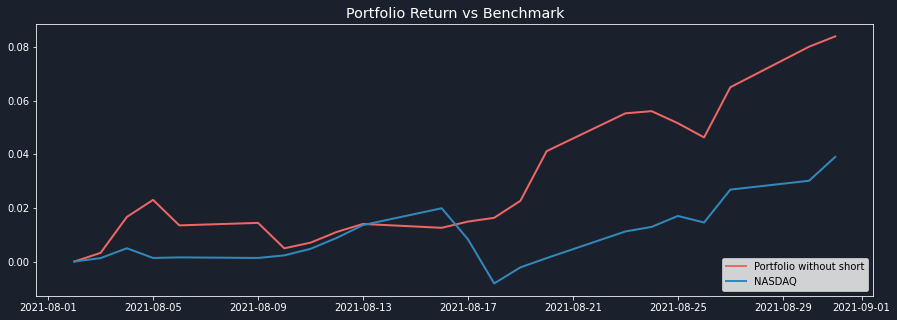

In [603]:
# min variance portfolio without short
end = dt.datetime(2021,8,31)
trade_start = dt.datetime(2021, 8, 1)

port_df = create_pf(tickers, start, end, ma_order, trade_start)
port_rtn, port_sharpe, port_ar, port_av = backtest(port_df,tickers,minvar_weights)
print("Min Var MA without Short: return = ", port_rtn)
print("Min Var MA without Short: sharpe ratio = ", port_sharpe)
print("Min Var MA without Short: annualized return = ", port_ar)
print("Min Var MA without Short: annualized volatility = ", port_av)

CVLG 21
TEAM 21
FOXA 21
NVDA 21
TSLA 21
CROX 21
GIII 21
JBLU 21
CZR 21
NFLX 21
Min Var MA without Short: return =  0.04513255890967116
Min Var MA without Short: sharpe ratio =  5.490058869514608
Min Var MA without Short: annualized return =  0.7599483976472694
Min Var MA without Short: annualized volatility =  0.13842263183499498


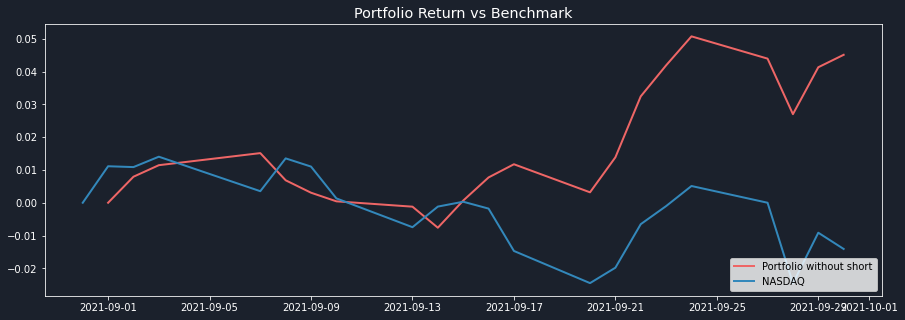

In [593]:
# min variance portfolio without short
end = dt.datetime(2021,9,30)
trade_start = dt.datetime(2021, 9, 1)

port_df = create_pf(tickers, start, end, ma_order, trade_start)
port_rtn, port_sharpe, port_ar, port_av = backtest(port_df,tickers,minvar_weights)
print("Min Var MA without Short: return = ", port_rtn)
print("Min Var MA without Short: sharpe ratio = ", port_sharpe)
print("Min Var MA without Short: annualized return = ", port_ar)
print("Min Var MA without Short: annualized volatility = ", port_av)

### 3. Testing

CVLG 21
TEAM 21
FOXA 21
NVDA 21
TSLA 21
CROX 21
GIII 21
JBLU 21
CZR 21
NFLX 21
Min Var MA without Short: return =  0.07833775191884462
Min Var MA without Short: sharpe ratio =  9.78997335753651
Min Var MA without Short: annualized return =  1.6200258938159524
Min Var MA without Short: annualized volatility =  0.16547806972005957


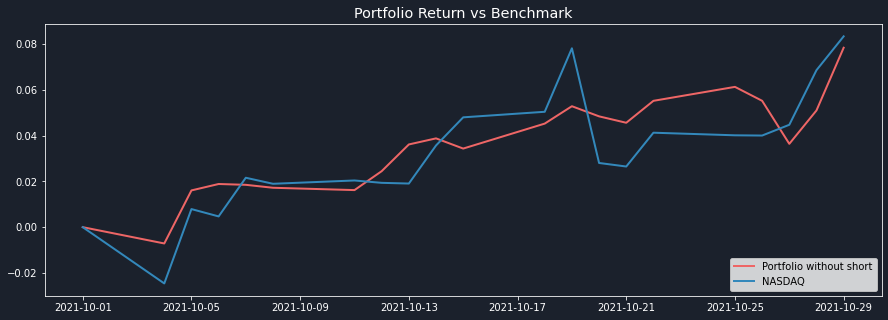

In [626]:
end = dt.datetime(2021,10,31)
trade_start = dt.datetime(2021, 10, 1)

port_df = create_pf(tickers, start, end, ma_order, trade_start)
port_rtn, port_sharpe, port_ar, port_av = backtest(port_df,tickers,minvar_weights)
print("Min Var MA without Short: return = ", port_rtn)
print("Min Var MA without Short: sharpe ratio = ", port_sharpe)
print("Min Var MA without Short: annualized return = ", port_ar)
print("Min Var MA without Short: annualized volatility = ", port_av)